## Opinion Mining/ Selenium

Постепенно подбираемся к теме Sentiment Analysis.

Для начала будем считать, что у текста есть
- полярность / polarity - является ли текст эмоционально окрашенным
- тональность / sentiment - как текст оценивает некий объект по шкале -1...1 / 0...1 / 1...5 и тд

Полезные источники данных:
- сайты отзывов / сайты интернет-магазинов (товары) - Amazon ....
- сайты с медиаконтентом - Youtube, Instagram ...
- специализированные сайты - Кинопоиск, IMDB, ...

Как скачивать оттуда данные?

- requests + fake_useragent
- Selenium 
  - возможность взаимодействия с элементами (кнопки, скролл и тп)
  - обходит капчу, тк имитирует браузер


Как запустить на своем компьютере:

1. Для начала нужно скачать chromedriver (https://chromedriver.chromium.org/downloads) в рабочую папку: у вас появится архив с бинарным файлом внутри. Архив нужно будет распаковать, а путь к папке добавить в path. Можно пользоваться драйверами различных браузеров, здесь я оставляю ссылки на версию google chrome.
2. В начале скрипта мы создаем какую-либо переменную, в которую помещаем наш браузер.
Пр.: driver = webdriver.Chrome(<полный путь к бинарному файлу>)
3. Открыть страницу можно с помощью функции get. 
Прокрутить страницу можно с помощью кода внизу.
4. Находить различные элементы страницы можно с помощью ряда функций find_elements_by_<...> (см. документацию).
Чтобы понять, как найти какой-либо элемент на странице, нужно в веб-инспекторе в браузере посмотреть путь элемента. В гугл-хроме это можно сделать, например, так: Посмотреть -> Разработчикам -> Проверить элементы -> Навести стрелкой на нужный элемент.
5. Как только мы нашли нужный элемент, можно на него кликнуть функцией .click() или посмотреть текст функцией .text().
6. В конце программы нужно  закрыть, если открывалли как сверху и, конечно, как -то сохранить ваши данные

Подробнее: https://towardsdatascience.com/how-to-scrape-youtube-comments-with-python-61ff197115d4

In [ ]:
!pip3 install selenium

## Данные

Возьмем противоречивое видео с ютьюба и попробуем проанализировать комментарии к нему
 https://www.youtube.com/watch?v=kuhhT_cBtFU&t=2s

## Тетрадка для подготовки данных 
[в Colab](https://colab.research.google.com/drive/1IFyhNz3UCvIEgHjskLNIgD0UddvxCkPw?usp=sharing)

In [ ]:
!pip install textblob stanza spacy

In [ ]:
# Загружаем модель для SpaCy
!python -m spacy download en_core_web_sm

In [97]:
import pandas as pd
import re, string
import nltk
from nltk.corpus import stopwords
import numpy as np
import stanza
import spacy
from textblob import TextBlob

spacy_nlp = spacy.load('en_core_web_sm')

stanza.download("en")
stanza_nlp = stanza.Pipeline("en", processors="tokenize,lemma,pos,sentiment")

nltk.download('stopwords')
nltk.download('punkt')
sw = stopwords.words('english')

# Очистка текстов
def clean_text(text):
    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)
    return text

2021-11-25 16:58:46 INFO: Downloading default packages for language: en (English)...
2021-11-25 16:58:47 INFO: File exists: /Users/rhubarb/stanza_resources/en/default.zip.
2021-11-25 16:58:51 INFO: Finished downloading models and saved to /Users/rhubarb/stanza_resources.
2021-11-25 16:58:51 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| sentiment | sstplus  |

2021-11-25 16:58:51 INFO: Use device: cpu
2021-11-25 16:58:51 INFO: Loading: tokenize
2021-11-25 16:58:51 INFO: Loading: pos
2021-11-25 16:58:52 INFO: Loading: lemma
2021-11-25 16:58:52 INFO: Loading: sentiment
2021-11-25 16:58:52 INFO: Done loading processors!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rhubarb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rhubarb/nltk_data...
[nltk_data]   Package punkt

In [98]:
def lemmatize(text):  # spacy
    doc = spacy_nlp(text)
    return [token.lemma_ for token in doc]

def lemmatize_stanza(text):  #stanza
    doc = stanza_nlp(text)
    return [word.lemma for sent in doc.sentences for word in sent.words]

In [99]:
def remove_stopwords(tokens):
    return [t for t in tokens if t not in sw]

In [100]:
def pipelinize(texts):
    return spacy_nlp.pipe(texts, disable=["parser", "ner"])

In [101]:
pd.set_option('display.max_colwidth', 1000)

In [102]:
a = pd.read_csv('youtube_comments.txt', sep='\t')

In [103]:
len(a)

440677

In [104]:
a['clean_text'] = a['text'].apply(lambda x: clean_text(x))

In [105]:
a.sample(frac=0.01)

,text,clean_text
149329,1 year ago,year ago
189890,Imagine if the cop just said we will have to give you a ride home you can’t operate your vehicle for the night. But not in this day and age where all of this at the end was about money not justice but money. America is not a country it’s a business.,imagine if the cop just said we will have to give you a ride home you cant operate your vehicle for the night but not in this day and age where all of this at the end was about money not justice but money america is not a country its a business
274964,2 Wrongs Dont Make A Right.,wrongs dont make a right
80653,Cathi Knows,cathi knows
274189,REPLY,reply
...,...,...
183068,"How can you try fight cops, steal their weapon and be susprised that they shot you lol",how can you try fight cops steal their weapon and be susprised that they shot you lol
323758,"We need to train officers proper CQC and some Jiu-Jitsu just to hold a person down. From there detain the person, place them in the car.",we need to train officers proper cqc and some jiujitsu just to hold a person down from there detain the person place them in the car
281679,He fought with officers and tried to steal their taser then ran off?,he fought with officers and tried to steal their taser then ran off
155732,Here we go again! Keep on fanning the flames CNN.,here we go again keep on fanning the flames cnn


In [106]:
sample_texts = a.sample(frac=0.1)

In [107]:
len(sample_texts)

44068

In [108]:
lemmas_comments = []
for doc in pipelinize(sample_texts['clean_text'].to_list()):
    lemmas_comments.append([token.lemma_ for token in doc])
sample_texts['lem'] = lemmas_comments

In [109]:
sample_texts['best'] = sample_texts['lem'].apply(lambda x: remove_stopwords(x))

In [110]:
sample_texts.sample(frac=0.01)

,text,clean_text,lem,best
60156,294,,[],[]
46063,"APD SHOOTING EXPLAINED\nBefore reading below, remember that officers are afforded the same constitutional rights as citizens, so whether they’re charged for political reasons or not, the facts of the case remain the same until their day in court:\nRead more\n3\nREPLY\nChristopher Hess\n1 year ago\nProportionality requires that any measure that interferes with fundamental rights has a legitimate public purpose and is also appropriate, necessary and proportionate in the narrower sense (appropriate""). A measure that does not meet these requirements is illegal. (german legal principle)",apd shooting explainedbefore reading below remember that officers are afforded the same constitutional rights as citizens so whether theyre charged for political reasons or not the facts of the case remain the same until their day in courtread year agoproportionality requires that any measure that interferes with fundamental rights has a legitimate public purpose and is also appropriate necessary and proportionate in the narrower sense appropriate a measure that does not meet these requirements is illegal german legal principle,"[apd, shoot, explainedbefore, read, below, remember, that, officer, be, afford, the, same, constitutional, right, as, citizen, so, whether, they, re, charge, for, political, reason, or, not, the, fact, of, the, case, remain, the, same, until, their, day, in, courtread, , year, agoproportionality, require, that, any, measure, that, interfere, with, fundamental, right, have, a, legitimate, public, purpose, and, be, also, appropriate, necessary, and, proportionate, in, the, narrow, sense, appropriate, a, measure, that, do, not, meet, these, requirement, be, illegal, german, legal, principle]","[apd, shoot, explainedbefore, read, remember, officer, afford, constitutional, right, citizen, whether, charge, political, reason, fact, case, remain, day, courtread, , year, agoproportionality, require, measure, interfere, fundamental, right, legitimate, public, purpose, also, appropriate, necessary, proportionate, narrow, sense, appropriate, measure, meet, requirement, illegal, german, legal, principle]"
354064,Don’t edit,dont edit,"[do, nt, edit]","[nt, edit]"
188049,1 year ago,year ago,"[ , year, ago]","[ , year, ago]"
326607,REPLY,reply,[reply],[reply]
...,...,...,...,...
271720,1 year ago,year ago,"[ , year, ago]","[ , year, ago]"
339888,"Do you know how you don't get shot in a wendy's parking lot when you're passed out drunk? Don't fight with the cops, then taze them.",do you know how you dont get shot in a wendys parking lot when youre passed out drunk dont fight with the cops then taze them,"[do, you, know, how, you, do, nt, get, shoot, in, a, wendys, parking, lot, when, you, re, pass, out, drunk, do, nt, fight, with, the, cop, then, taze, they]","[know, nt, get, shoot, wendys, parking, lot, pass, drunk, nt, fight, cop, taze]"
252097,REPLY,reply,[reply],[reply]
31549,Humble Beauty,humble beauty,"[humble, beauty]","[humble, beauty]"


## Предварительный статистический анализ

Как предварительно проанализировать данные, чтобы понимать, куда копать?

### Посмотрим на распределение частот лемм

1. Составить список всех лемм
2. Составить частотный словарь `nltk.FreqDist`

In [119]:
#Your code here - freq
lemmas = []
for comment in sample_texts['best'].to_list():
    for l in comment:
        if not l.strip():
            continue
        lemmas.append(l)
freqs = nltk.FreqDist(lemmas)

In [120]:
?freqs

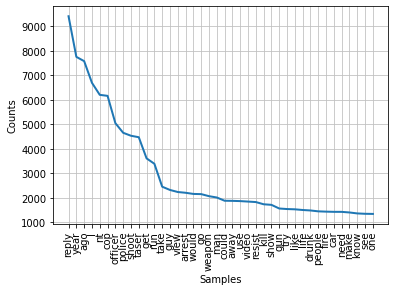

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [132]:
freqs.plot(40)

In [133]:
freqs.most_common(50)

[('reply', 9411),
 ('year', 7753),
 ('ago', 7578),
 ('I', 6693),
 ('nt', 6202),
 ('cop', 6161),
 ('officer', 5047),
 ('police', 4653),
 ('shoot', 4532),
 ('taser', 4472),
 ('get', 3608),
 ('run', 3388),
 ('take', 2452),
 ('guy', 2319),
 ('view', 2235),
 ('arrest', 2204),
 ('would', 2157),
 ('go', 2149),
 ('weapon', 2065),
 ('man', 2011),
 ('could', 1879),
 ('away', 1874),
 ('use', 1864),
 ('video', 1845),
 ('resist', 1825),
 ('kill', 1735),
 ('show', 1711),
 ('gun', 1562),
 ('try', 1540),
 ('like', 1529),
 ('life', 1501),
 ('drunk', 1482),
 ('people', 1446),
 ('fire', 1434),
 ('car', 1426),
 ('need', 1425),
 ('make', 1400),
 ('know', 1361),
 ('see', 1346),
 ('one', 1341),
 ('think', 1257),
 ('back', 1184),
 ('let', 1177),
 ('drive', 1136),
 ('point', 1133),
 ('fight', 1116),
 ('say', 1048),
 ('time', 1028),
 ('force', 981),
 ('cnn', 979)]

### Посмотрим на частоты биграмм и триграмм:
- `nltk.bigrams`

In [125]:
bigrams = []
for comment in sample_texts['best'].to_list():
    for b in nltk.bigrams(comment):
        bigrams.append(b)

In [128]:
b_freq = nltk.FreqDist(bigrams)

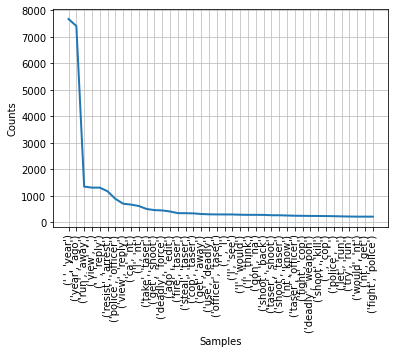

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [130]:
b_freq.plot(40)

In [134]:
b_freq.most_common(50)

[((' ', 'year'), 7670),
 (('year', 'ago'), 7404),
 (('run', 'away'), 1348),
 (('view', ' '), 1309),
 ((' ', 'reply'), 1309),
 (('resist', 'arrest'), 1171),
 (('police', 'officer'), 885),
 (('view', 'reply'), 702),
 (('ca', 'nt'), 669),
 (('I', 'nt'), 615),
 (('take', 'taser'), 503),
 (('get', 'shoot'), 460),
 (('deadly', 'force'), 448),
 (('ago', 'edit'), 409),
 (('fire', 'taser'), 346),
 (('steal', 'taser'), 344),
 (('cop', 'taser'), 337),
 (('get', 'away'), 313),
 (('use', 'deadly'), 302),
 (('officer', 'taser'), 298),
 ((' ', 'I'), 297),
 (('I', 'see'), 296),
 (('I', 'would'), 286),
 (('I', 'think'), 282),
 (('gon', 'na'), 282),
 (('shoot', 'back'), 280),
 (('taser', 'shoot'), 267),
 (('shoot', 'taser'), 266),
 (('nt', 'know'), 257),
 (('taser', 'officer'), 248),
 (('fight', 'cop'), 245),
 (('deadly', 'weapon'), 241),
 (('shoot', 'kill'), 239),
 ((' ', 'cop'), 236),
 (('police', ' '), 231),
 (('let', 'run'), 224),
 (('try', 'run'), 218),
 (('would', 'nt'), 214),
 (('nt', 'get'), 214

In [ ]:
#trigram freq

### А если убрать слишком короткие комментарии?

## TextBlob

Простая библиотека, которая совмещает статистические методы и regexp-паттерны.

The sentiment property returns a namedtuple of the form `Sentiment(polarity, subjectivity)`. 

The polarity score is a float within the range [-1.0, 1.0]. 

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [135]:
blob = TextBlob(sample_texts['text'][46063])
blob.sentiment

Sentiment(polarity=0.10909090909090909, subjectivity=0.3287878787878788)

In [136]:
blob.sentiment_assessments

Sentiment(polarity=0.10909090909090909, subjectivity=0.3287878787878788, assessments=[(['same'], 0.0, 0.125, None), (['political'], 0.0, 0.1, None), (['same'], 0.0, 0.125, None), (['more'], 0.5, 0.5, None), (['public'], 0.0, 0.06666666666666667, None), (['appropriate'], 0.5, 0.5, None), (['necessary'], 0.0, 1.0, None), (['appropriate'], 0.5, 0.5, None), (['illegal'], -0.5, 0.5, None), (['german'], 0.0, 0.0, None), (['legal'], 0.2, 0.2, None)])

In [137]:
def comment_sentiment(comment):
    blob = TextBlob(comment)
    return np.mean([s.sentiment.polarity for s in blob.sentences])


In [138]:
sample_texts['sent'] = sample_texts['text'].apply(lambda x: comment_sentiment(x))

In [139]:
sample_texts

,text,clean_text,lem,best,sent
411182,1 year ago,year ago,"[ , year, ago]","[ , year, ago]",0.000000
214487,"I'm a huge supporter of the defund the police movement, but this was clearly not police brutality Rayshard completely messed up. should he have died no and it's unfortunate but this is not the same as Goerge Floyd and I hope the movement doesn't stick to its guns on this on when there is clear evidence of police brutality elsewhere.",im a huge supporter of the defund the police movement but this was clearly not police brutality rayshard completely messed up should he have died no and its unfortunate but this is not the same as goerge floyd and i hope the movement doesnt stick to its guns on this on when there is clear evidence of police brutality elsewhere,"[I, m, a, huge, supporter, of, the, defund, the, police, movement, but, this, be, clearly, not, police, brutality, rayshard, completely, mess, up, should, he, have, die, no, and, its, unfortunate, but, this, be, not, the, same, as, goerge, floyd, and, I, hope, the, movement, do, nt, stick, to, its, gun, on, this, on, when, there, be, clear, evidence, of, police, brutality, elsewhere]","[I, huge, supporter, defund, police, movement, clearly, police, brutality, rayshard, completely, mess, die, unfortunate, goerge, floyd, I, hope, movement, nt, stick, gun, clear, evidence, police, brutality, elsewhere]",0.008333
325807,1 year ago,year ago,"[ , year, ago]","[ , year, ago]",0.000000
240022,"Some comments are saying that the level of force that the police are shown to use in this video is ' legit' IT WAS NOT! Those police had NO REASON to shoot/kill an unarmed, frightened, drunk guy who was simply trying to run away from them! 'Resisting arrest' is NOT, and should not BE, a death penalty legal offense! I'm not saying that fighting the cops was the right thing to do. I'm saying that we hage to be able to trust that men and women on the police force will be more calm, more level headed, better behaved, and more aware of/accountable to the law than the people who they are policing.",some comments are saying that the level of force that the police are shown to use in this video is legit it was not those police had no reason to shootkill an unarmed frightened drunk guy who was simply trying to run away from them resisting arrest is not and should not be a death penalty legal offense im not saying that fighting the cops was the right thing to do im saying that we hage to be able to trust that men and women on the police force will be more calm more level headed better behaved and more aware ofaccountable to the law than the people who they are policing,"[some, comment, be, say, that, the, level, of, force, that, , the, police, be, show, to, use, in, this, video, be, , legit, , it, be, not, those, police, have, no, reason, to, shootkill, an, unarmed, frightened, drunk, guy, who, be, simply, try, to, run, away, from, they, resist, arrest, be, not, and, should, not, be, a, death, penalty, legal, offense, I, m, not, say, that, fight, the, cop, be, the, right, thing, to, do, I, m, say, that, we, hage, to, be, able, to, trust, that, man, and, woman, on, the, police, force, will, be, more, calm, more, level, ...]","[comment, say, level, force, , police, show, use, video, , legit, , police, reason, shootkill, unarmed, frightened, drunk, guy, simply, try, run, away, resist, arrest, death, penalty, legal, offense, I, say, fight, cop, right, thing, I, say, hage, able, trust, man, woman, police, force, calm, level, head, well, behave, aware, ofaccountable, law, people, police]",0.114286
100724,REPLY,reply,[reply],[reply],0.000000
...,...,...,...,...,...
114218,Todd Bertram,todd bertram,"[todd, bertram]","[todd, bertram]",0.000000
439929,Plis not 'shorten' and 'combine' the video...,plis not shorten and combine the video,"[pli, not, shorten, and, combine, the, video]","[pli, shorten, combine, video]",0.000000
209565,REPLY,reply,[reply],[reply],0.000000
80122,the cop was wrong but do what the

<AxesSubplot:title={'center':'Comments Polarity'}, ylabel='Frequency'>

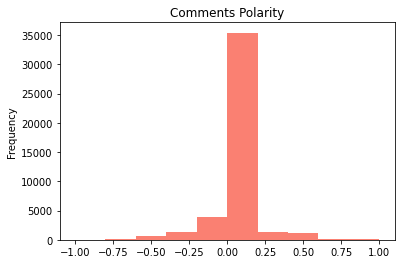

In [140]:
sample_texts['sent'].plot.hist(color='salmon', title='Comments Polarity')

In [141]:
sample_texts[sample_texts['sent']<-0.5]

,text,clean_text,lem,best,sent
75498,#VERY FAKE NEWS 😂🤣😅,very fake news,"[very, fake, news]","[fake, news]",-0.650000
332489,Well that was worthless commentary.,well that was worthless commentary,"[well, that, be, worthless, commentary]","[well, worthless, commentary]",-0.800000
279096,Another man had died because of his stupidity.,another man had died because of his stupidity,"[another, man, have, die, because, of, his, stupidity]","[another, man, die, stupidity]",-0.600000
339770,Bad decisions meeting Bad Practice...,bad decisions meeting bad practice,"[bad, decision, meet, bad, practice]","[bad, decision, meet, bad, practice]",-0.700000
267513,Bad decisions meeting Bad Practice...,bad decisions meeting bad practice,"[bad, decision, meet, bad, practice]","[bad, decision, meet, bad, practice]",-0.700000
...,...,...,...,...,...
283646,"Just terrible that lethal force was used. If he just wasn't drunk, blocked a business, failed a FST, resisted arrest, fought with them to get away, TOOK THE LEOs TASER, FIRED IT AT HIM while fleeing....none of this would have ever happened.",just terrible that lethal force was used if he just wasnt drunk blocked a business failed a fst resisted arrest fought with them to get away took the leos taser fired it at him while fleeingnone of this would have ever happened,"[just, terrible, that, lethal, force, be, use, if, he, just, be, nt, drunk, block, a, business, fail, a, fst, resist, arrest, fight, with, they, to, get, away, take, the, leo, taser, fire, it, at, he, while, fleeingnone, of, this, would, have, ever, happen]","[terrible, lethal, force, use, nt, drunk, block, business, fail, fst, resist, arrest, fight, get, away, take, leo, taser, fire, fleeingnone, would, ever, happen]",-0.675000
421868,What a load of crap I don't still don't think the cop did anything wrong if he had been hit with the taser the guy could have took his gun,what a load of crap i dont still dont think the cop did anything wrong if he had been hit with the taser the guy could have took his gun,"[what, a, load, of, crap, I, do, nt, still, do, nt, think, the, cop, do, anything, wrong, if, he, have, be, hit, with, the, taser, the, guy, could, have, take, his, gun]","[load, crap, I, nt, still, nt, think, cop, anything, wrong, hit, taser, guy, could, take, gun]",-0.650000
98046,Cant fix stupid.,cant fix stupid,"[ca, nt, fix, stupid]","[ca, nt, fix, stupid]",-0.800000
10508,This is causing anxiety that it’s literally making me sick.,this is causing anxiety that its literally making me sick,"[this, be, cause, anxiety, that, its, literally, make, I, sick]","[cause, anxiety, literally, make, I, sick]",-0.714286


## Stanza Sentiment Analysis

In [142]:
stanza_sentiment = ['negative', 'neutral', 'positive']
for sentence in stanza_nlp(sample_texts['clean_text'][46063]).sentences:
    print(stanza_sentiment[sentence.sentiment])

negative


In [143]:
sample_texts['clean_text'][46063]

'apd shooting explainedbefore reading below remember that officers are afforded the same constitutional rights as citizens so whether theyre charged for political reasons or not the facts of the case remain the same until their day in courtread   year agoproportionality requires that any measure that interferes with fundamental rights has a legitimate public purpose and is also appropriate necessary and proportionate in the narrower sense appropriate a measure that does not meet these requirements is illegal german legal principle'